In [1]:
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Chargement des données

In [3]:
import os

with open("/content/drive/My Drive/Datasets/Data_semEval2022/Fr_data/fr.train.json", "r") as file_handler:
    dataset = json.load(file_handler)

In [4]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/Fr_data/fr.dev.json", "r") as file_handler:
    dataset_dev = json.load(file_handler)

In [5]:
sgns = [i['char'] for i in dataset]
glosses = [i['gloss'] for i in dataset]

In [6]:
sgns_dev = [i['char'] for i in dataset_dev]
glosses_dev = [i['gloss'] for i in dataset_dev]

In [7]:
print(len(glosses_dev))

6375


In [8]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemm2Idx_train.json") as outfile:
    lemm2Idx = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/idx2Lemm_train.json") as outfile:
    idx2Lemm = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemmatized_glosses_train.json") as outfile:
    lemmatized_glosses = json.load(outfile)

In [9]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemm2Idx.json") as outfile:
    lemm2Idx_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/idx2Lemm.json") as outfile:
    idx2Lemm_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemmatized_glosses.json") as outfile:
    lemmatized_glosses_dev = json.load(outfile)

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Préparation des données

In [11]:
lemmatized_glosses_text = []

for gloss in lemmatized_glosses:
    text = ""
    for word in gloss:
        text += idx2Lemm[str(word)] + " "
    lemmatized_glosses_text.append(text)

In [12]:
print(len(lemmatized_glosses_text))
print(len(sgns))


43608
43608


In [13]:
lemmatized_glosses_text_dev = []

for gloss in lemmatized_glosses_dev:
    text = ""
    for word in gloss:
        text += idx2Lemm_dev[str(word)] + " "
    lemmatized_glosses_text_dev.append(text)

In [14]:
print(len(lemmatized_glosses_text_dev))
print(len(sgns_dev))

6375
6375


In [15]:
def longest_gloss(glosses_list):
    lgt = 0
    sentence = ""
    tk = []
    for g in glosses_list :
        tokens = g.split()
        if len(tokens)>lgt :
            lgt = len(tokens)
            sentence =g
            tk = tokens
    return lgt, tk, sentence

In [16]:
max_len, tk, stc = longest_gloss(lemmatized_glosses_text)
print(max_len)
print(tk)
print(stc)

149
['ornithologie', 'Nom', 'normaliser', 'donner', 'à', 'quatre', 'genre', 'renfermer', '17', 'espèce', 'de', 'oiseau', 'grimpeur', 'mangeur', 'de', 'cire', 'de', 'abeille', 'ou', 'un', 'autre', 'source', 'tel', 'certain', 'insecte', 'et', 'de', 'le', 'couvain', 'de', 'le', 'ruche', 'de', 'le', 'famille', 'de', 'le', 'indicatoridé', 'ordre', 'de', 'le', 'piciforme', 'qui', 'nicher', 'dans', 'le', 'forêt', 'épars', 'de', 'le', 'Afrique', 'subsaharien', 'et', 'en', 'Asie', 'de', 'le', 'sud-est', 'et', 'qui', 'être', 'caractériser', 'par', 'son', 'bec', 'conique', 'fort', 'et', 'légèrement', 'incurvé', 'son', 'plumage', 'terne', 'mais', 'garni', 'de', 'plage', 'blanc', 'ou', 'jaune', 'très', 'visible', 'à', 'distance', 'sur', 'le', 'queue', 'le', 'croupion', 'ou', 'le', 'flanc', 'par', 'le', 'parasitisme', 'de', 'couvée', 'que', 'il', 'pratiquer', 'à', 'le', 'façon', 'de', 'le', 'coucous', 'et', 'par', 'son', 'grand', 'facilité', 'à', 'dénicher', 'le', 'nid', 'de', 'abeille', 'un', 'cara

In [17]:
max_len_dev, tk, stc = longest_gloss(lemmatized_glosses_text_dev)
print(max_len_dev)

111


In [18]:
max_tokens = len(list(lemm2Idx))
print(max_tokens)
max_tokens_dev = len(lemm2Idx_dev)

max_len = 149
max_len_dev = 111
vectorize_layer = TextVectorization(
    # Max vocab size. Any words outside of the max_tokens most common ones
    # will be treated the same way: as "out of vocabulary" (OOV) tokens.
    max_tokens=24091,
    # Output integer indices, one per string token
    output_mode="int",
    # Always pad or truncate to exactly this many tokens
    output_sequence_length=max_len
)

24089


In [19]:
# Call adapt(), which fits the TextVectorization layer to our text dataset.
# This is when the max_tokens most common words (i.e. the vocabulary) are selected.
vectorize_layer.adapt(np.array(list(idx2Lemm.values())))

In [ ]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/vocab_file.json", "r", encoding="utf8") as vocabulary_file:
    vocab = json.load(vocabulary_file)

In [ ]:
vectorizer = TfidfVectorizer(vocabulary = list(idx2Lemm.values()))
vecteur = vectorizer.fit_transform(lemmatized_glosses_text)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(vecteur)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


TfidfTransformer()

In [ ]:
print("vocab",len(vocab['idf_weights']))
print("idx", len(list(idx2Lemm.values())))
print(vectorize_layer.vocabulary_size())

vocab 24053
idx 24089
22609


In [ ]:
vectorize_layer.set_vocabulary(
    list(vectorizer.get_feature_names()), idf_weights=None)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(np.array(list(idx2Lemm.values())[0]))

par


In [ ]:
def meanIDFweights(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
    	signature="default", as_dict=True)["default"]

### Construction du modèle

In [20]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 28.5 MB/s 


In [21]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor

lr = 1e-1 * schedule(step)

learning_rate=1e-3

wd = lambda: 1e-4 * schedule(step)

weight_decay=1e-6,

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [23]:
import torch.optim as optim

opt = keras.optimizers.Adam(learning_rate=0.01)

In [22]:
model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

In [23]:
model.add(vectorize_layer)

In [24]:
from tensorflow.keras import layers
# Note that we're using max_tokens + 1 here, since there's an
# out-of-vocabulary (OOV) token that gets added to the vocab.

len_gloses = 43608

model.add(Embedding(max_tokens + 1, 128))

model.add(Dense(128))

model.add(Bidirectional(LSTM(units=192, return_sequences=True), merge_mode = 'ave'))

model.add(Dense(192))

model.add(LSTM(units=256, return_sequences=False, activation = "softmax"))


model.add(Dense(256))

In [25]:
 model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 149)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 149, 128)          3083520   
                                                                 
 dense (Dense)               (None, 149, 128)          16512     
                                                                 
 bidirectional (Bidirectiona  (None, 149, 192)         493056    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 149, 192)          37056     
                                                                 
 lstm_1 (LSTM)               (None, 256)               4

### Entraînement du modèle

In [27]:
with tf.device('/device:GPU:0'):
  history = model.fit(lemmatized_glosses_text, sgns,
                    epochs=25,
                    batch_size=192,
                    validation_data=(lemmatized_glosses_text_dev,  sgns_dev))

Epoch 1/25
228/228 [==============================] - 86s 347ms/step - loss: 0.7116 - accuracy: 2.5225e-04 - val_loss: 0.6091 - val_accuracy: 1.5686e-04
Epoch 2/25
228/228 [==============================] - 73s 318ms/step - loss: 0.5621 - accuracy: 2.2932e-05 - val_loss: 0.5196 - val_accuracy: 0.0000e+00
Epoch 3/25
228/228 [==============================] - 72s 317ms/step - loss: 0.4958 - accuracy: 0.5483 - val_loss: 0.4701 - val_accuracy: 0.7514
Epoch 4/25
228/228 [==============================] - 74s 326ms/step - loss: 0.4565 - accuracy: 0.7580 - val_loss: 0.4387 - val_accuracy: 0.7514
Epoch 5/25
228/228 [==============================] - 75s 328ms/step - loss: 0.4306 - accuracy: 0.7580 - val_loss: 0.4174 - val_accuracy: 0.7514
Epoch 6/25
228/228 [==============================] - 73s 321ms/step - loss: 0.4127 - accuracy: 0.7580 - val_loss: 0.4024 - val_accuracy: 0.7514
Epoch 7/25
228/228 [==============================] - 73s 318ms/step - loss: 0.4000 - accuracy: 0.7580 - val_loss:

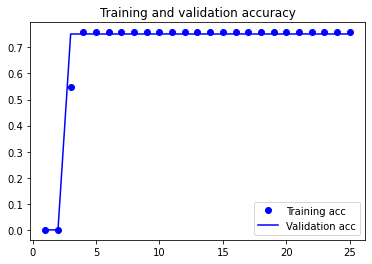

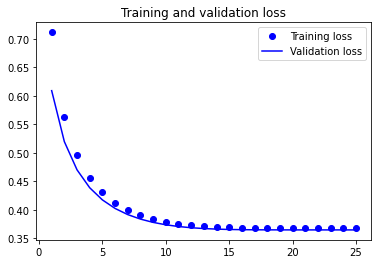

In [28]:
#Visualisation des résultats de l'entraînement.
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
#sauvegarde du modèle
model.save('new_fr_revdict_model.tf')

INFO:tensorflow:Assets written to: new_fr_revdict_model.tf/assets


INFO:tensorflow:Assets written to: new_fr_revdict_model.tf/assets



### Test du modèle sur les données Trial

In [118]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/Fr_data/fr.trial.complete.json", "r") as file_handler:
    dataset_trial = json.load(file_handler)

In [119]:
glosses_trial = []
for e in dataset_trial :
    glosses_trial.append(e["gloss"])

In [120]:
sgns_trial = []
for e in dataset_trial :
    sgns_trial.append(e["sgns"])

In [121]:
scores = model.evaluate(glosses_trial, sgns_trial, verbose=2)

7/7 - 0s - loss: 2.2708 - accuracy: 0.0250 - 307ms/epoch - 44ms/step


In [122]:
classes = model.predict(glosses_trial, batch_size=32)

In [123]:
print(len(classes))

200


In [124]:
print(len(classes[0]))

256


In [125]:
results = []

prefix_id = "fr.revdict.trial."
i = 0
for g in glosses_trial :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes[glosses_trial.index(g)]
  results.append(sample)
  i+=1


print("vecteur trial ---> prédiction")
for v in sgns[0] :
  print(v, " ---> ", results[0]["sgns"][list(sgns[0]).index(v)])

#print(len(results))

vecteur trial ---> prédiction
-1.8197561502  --->  -0.56618357
0.7276539803  --->  0.85050595
3.0497694016  --->  1.5324044
0.4060807824  --->  0.33401352
0.8143484592  --->  0.48414928
-0.0318837762  --->  0.12086853
0.668138206  --->  1.1185892
0.1325415075  --->  -0.17863664
0.8312900662  --->  0.44012693
0.6226500869  --->  0.763168
1.288936615  --->  0.67726016
0.1087394431  --->  0.24367034
-2.0277197361  --->  -3.835167
0.5347809792  --->  0.19123667
-0.4531050324  --->  0.15306193
-0.131837368  --->  0.109227225
0.0606372654  --->  0.31449443
0.0607398115  --->  0.052809644
0.3923100829  --->  -0.1236882
0.0052511543  --->  0.11495325
2.78210783  --->  1.4289002
-0.2999051213  --->  -0.68992037
-0.0685113966  --->  -0.013070984
0.0379348397  --->  0.065962136
0.1870228946  --->  0.12805273
-0.133666575  --->  0.13599919
-0.0153277516  --->  0.044802688
0.1531549692  --->  0.3001734
-0.0749418363  --->  -0.03341917
-0.421436429  --->  -0.27521187
0.0716482624  --->  0.39036676
0

In [126]:
import pandas as pd
pd.Series(results).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/fr_revdict_results_prediction_trial.json", orient='values')

### Calcule des métriques d'évaluation

In [127]:
import torch.nn.functional as F
import torch

classes_tensor = torch.tensor(classes)
sgns_trial_tensor = torch.tensor(sgns_trial)

In [128]:
cos_sim = F.cosine_similarity(classes_tensor, sgns_trial_tensor).mean().item()

In [129]:
print(cos_sim)

-0.0008589401841163635


In [130]:
mse = F.mse_loss(classes_tensor, sgns_trial_tensor).item()

In [131]:
print(mse)

2.270761728286743


In [132]:
# fonction prise du code de la baseline.
def rank_cosine(preds, targets):
    unique_targets = targets.unique(dim=0)
    all_assocs = preds @ F.normalize(targets).T
    unique_assocs = preds @ F.normalize(unique_targets).T
    refs = torch.diagonal(all_assocs, 0).unsqueeze(1)
    ranks = (unique_assocs >= refs).sum(1).float().mean().item()
    return ranks / unique_targets.size(0)

In [133]:
rnk = rank_cosine(classes_tensor, sgns_trial_tensor)

In [134]:
print(rnk)

0.5047487421850463


### Test du modèle sur les données de DEV


In [135]:
scores = model.evaluate(glosses_dev, sgns_dev, verbose=2)

200/200 - 7s - loss: 0.3647 - accuracy: 0.7514 - 7s/epoch - 33ms/step


In [136]:
classes_dev = model.predict(glosses_dev, batch_size=32)

In [137]:
print(len(classes_dev))

6375


In [138]:
print(len(classes_dev[0]))

256


In [141]:
results_dev = []

prefix_id = "fr.revdict.dev."
i = 0
for g in glosses_dev :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_dev[glosses_dev.index(g)]
  results_dev.append(sample)
  i+=1


print("vecteur dev ---> prédiction")
for v in sgns_dev[0] :
  print(v, " ---> ", results_dev[0]["sgns"][list(sgns_dev[0]).index(v)])

vecteur dev ---> prédiction
0.0130068734  --->  -0.56618357
0.6688424349  --->  0.85050595
-0.0436479375  --->  1.5324044
-0.0079411808  --->  0.33401352
-0.0245929956  --->  0.48414928
-0.2760707736  --->  0.12086853
0.560736239  --->  1.1185892
-0.4518419504  --->  -0.17863664
0.35933882  --->  0.44012693
0.8757936358  --->  0.763168
0.8935328722  --->  0.67726016
0.3995228112  --->  0.24367034
-5.8919038773  --->  -3.835167
-0.4046234488  --->  0.19123667
1.1598460674  --->  0.15306193
-0.4411924779  --->  0.109227225
1.2142043114  --->  0.31449443
0.0324933156  --->  0.052809644
-0.3487933874  --->  -0.1236882
-0.0569673069  --->  0.11495325
0.9960999489  --->  1.4289002
-0.5367333293  --->  -0.68992037
-0.063915059  --->  -0.013070984
0.0420465581  --->  0.065962136
0.0972432643  --->  0.12805273
0.2754342258  --->  0.13599919
6.39558e-05  --->  0.044802688
1.1848087311  --->  0.3001734
-0.0954852402  --->  -0.03341917
-0.4623927474  --->  -0.27521187
0.6340706944  --->  0.3903667

In [140]:
import pandas as pd
pd.Series(results_dev).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/fr_revdict_results_prediction_dev.json", orient='values')

In [142]:
print(len(results_dev))

6375
